# Some analytic facts about variational quantum algorithms
> Parameter shift rules, sequential optimization, average performance: it's mostly basic trigonometry, really.
- toc: true 
- badges: true
- comments: true
- categories: [QML,VQA, VQE]
- image: images/pisa.svg

In [2]:
#collapse

from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from math import pi

# Introduction

Variational quantum algorithms (VQA) is a huge field by now with many prospective applications and a poll of advocates for their potential quantum advantage on the NISQ devices, see e.g. [here](https://arxiv.org/abs/2012.09265) for a recent review. I usually think of variational quantum algorithms as analogues of the neural networks with a parametrized quantum circuit playing the role of a trainable model. Here is an example of a parametrized quantum circuit:

<img src="myimages/analytic_vqe/pqc.png" alt="Drawing" style="width: 1000px;"/>

Despite certain similarities there are also crucial distinctions between the classical and quantum nets, manifesting both in their functional shapes and trainability properties. Here I will mostly talk about some functional properties of parametrized quantum circuits, and briefly touch on the trainability issues at the end. 
A whole slew of additional peculiarities arise when you want to run quantum circuits on real quantum hardware and have to deal with errors and stochastic nature of measurements. Here I will ignore these issues completely, effectively assuming that we can run a classical simulation of the quantum circuit. 

## Hi $\cos$, hi $\sin$!

For a generic neural net the loss function is a highly non-linear function of each weight, due to non-linear activation functions that connect the layers. In contrast, dependence of the parametrized quantum circuits on each single parameter separately is extremely simple.

I will denote the unitary matrix of a parametrized quantum circuit by $U(\theta)$, with $\theta$ standing for all the parameters collectively. A simple observation, and really the basis for all of the following discussion, is the following equation
\begin{align}
U(\theta_i)=U_0 \cos \frac{\theta_i}{2}+U_1\sin\frac{\theta_i}{2} \label{u cos sin} \ .
\end{align}
Here $\theta_i$ stands for any parameter of the circuit, other are assumed to be fixed. Matrix coefficients $U_0$ and $U_1$ are given by $U_0=U(0)$ and $U_1 = U(\pi)$. Relation \eqref{u cos sin} follows from the simple fact that all gates typically considered in VQA are of the form 
\begin{align*}
G(\theta) = e^{-i\theta \Sigma /2}
\end{align*}
with a generator $\Sigma$ that satisfies $\Sigma^2=1$. Hence, by a generalization of Euler's formula $e^{i\phi}=\cos \phi+i\sin\phi$ any gate can be alternatively written as 
\begin{align*}
G(\theta) = \cos \frac{\theta}{2}-i\Sigma\sin\frac{\theta}{2} \ .
\end{align*}
As an example one take any single-qubit Pauli rotation [ref](https://qiskit.org/documentation/stubs/qiskit.circuit.library.RXGate.html), say $R_X(\theta)=e^{-i \theta X/2}=\cos \frac{\theta}{2}-iX\sin\frac{\theta}{2}$. Parametric two-qubit gates, e.g. [$R_{ZX}$ gate](https://qiskit.org/documentation/stubs/qiskit.circuit.library.RZXGate.html), usually conform to the same rule. Because of the trigonometric function here the parameters in VQA are often referred to as _angles_, the terminology which I will follow.

## A typical loss function

A subset of the VQA are variational quantum eigensolvers (VQE). A typical loss function in VQE is _quadratic_ in $U(\theta)$. For instance, one common goal in VQE is to prepare the ground state of some Hamiltonian $H$ using an ansatz $|\psi(\theta)\rangle = U(\theta)|0\rangle$. The relevant cost function to be minimized is

\begin{align}
L(\theta)=\langle\psi(\theta)|H|\psi(\theta)\rangle \label{loss VQE} \ .
\end{align}

In the unitary synthesis problem, that I've been recently interested in, the goal is to make the circuit $U(\theta)$ equivalent to some target unitary $V$. The relevant loss can be defined as

\begin{align*}
L(\theta)=-|\operatorname{Tr} V^\dagger U(\theta)|^2
\end{align*}

You got the idea. Note that while the circuit $U(\theta)$ has only two terms \eqref{u cos sin} as a function of any angle $\theta_i$, the quadratic loss function will have three terms (note also the period doubling)

\begin{align*}
L(\theta_i)=A \cos\theta_i+B \sin \theta_i + C \ .
\end{align*}

Here $A, B, C$ are functions of all the other angles except for $\theta_i$. They are the only unknowns that specify dependence on any particular angle and can be found with just three evaluations of the loss function, e.g.

\begin{align*}
A+B = L(0),\qquad A+C=L(\pi/2),\qquad A-C = L(-\pi/2) \Rightarrow\\
A = \frac{L(\pi/2)+L(-\pi/2)}{2},\qquad C=\frac{L(\pi/2)-L(-\pi/2)}{2},\qquad B = L(0)-A \ .
\end{align*}

## Parameter shift rule

Perhaps the best known consequence of this property is the parameter shift rule for derivatives. First, a bit of a background. Let's assume we need to estimate the derivative of some function $f(x)$ that we only have numerical access to. Then, there is nothing much better one can do than to use the finite difference approximations. For example, using two function evaluations it is possible to compute the first derivative up to the second approximation order

\begin{align*}
f'(x)=\frac{f(x+\epsilon)-f(x-\epsilon)}{2\epsilon}+O(\epsilon^2)
\end{align*}
In general, adding one more evaluation point allows to improve the accuracy by one order. However, when you have additional knowledge about the function much more efficient strategy may exists. In particular, for VQE loss functions \eqref{loss VQE} an _exact_ derivative computation is possible with just two function evaluations 

\begin{align*}
L'(\theta_i)=-A \sin(\theta_i)+B\cos{\theta_i}=\frac{L(\theta_i+\pi/2)-L(\theta_i-\pi/2)}{2} \ ,
\end{align*}
which follows from $\sin(x+\pi/2)=\cos x,\,\,\cos(x+\pi/2)=-\sin x$. Having access to exact derivatives generally enhances the performance of the gradient-based optimizers.

## Sequential optimization

An interesting extension of this idea, that is apparently much less known than the parameter-shift rule itself, was proposed in [http://arxiv.org/abs/1903.12166](http://arxiv.org/abs/1903.12166) (I believe there another independent paper introducing the same method, but I can't find it now). Instead of using structural properties of \eqref{loss VQE} to just compute derivatives, one can find the exact minimum of $L(\theta_i)$ with respect to any angle $\theta_i$ (assuming other angles are fixed). I.e. instead of a partial derivative one can compute "the partial minimum".

Indeed, since just three three evaluations fix $L(\theta_i)$ completely, and the function itself is rather simple, there is no problem finding $\operatorname{argmin}_{\theta_i}L(\theta_i)$ exactly. The explicit formula could be more transparent, but it is a simple trigonometry in the end (double check if you a going to use it!)

\begin{align*}
\theta^*=\operatorname{argmin}_{\theta}\left(A \cos\theta+B\sin\theta+C\right)=\cases{\arctan \frac{B}{A}+\pi,&A>0\\\arctan \frac{B}{A},& A<0}
\end{align*}

With this trick one can bypass gradient-based optimization as follows. Starting from $L(\theta_1,\theta_2,\dots)$ first optimize with respect to the first angle $L(\theta_1,\theta_2,\dots)\to L(\theta_1^*,\theta_2,\dots)$. Then optimize with respect to the second $L(\theta_1^*,\theta_2,\dots)\to L(\theta_1^*,\theta_2^*,\dots)$. Note that after this step the first angle in general no longer is the best choice, because the second angle has changed. Still, one can continue this procedure further until all angles are updated and then start anew. Each step is guaranteed to decrease the value of the loss function. If the loss landscape is nice overall, this sequential gradient-free optimization may in fact even outperform gradient-based methods. Unfortunately, to my understanding the sequential optimization is unlikely to help with the most crucial problems in the VQE loss landscapes: barren plateaus and local minimums.

## Average performance of the VQE

Here comes the original contribution of this blog post, I will show how to compute (semi-efficiently) the _average loss_ 
\begin{align}
\overline{L}=\frac{1}{(2\pi)^p}\int \prod_{i=1}^p d\theta_i \langle \psi(\theta)|H|\psi(\theta)\rangle \ .
\end{align}
where $p$ is the total number of angles in the parametrized circuit. Why would one be interested in such a quantity? Honestly, I do not know, but hey, this is a blog post and not a paper, so I'll take a recreational attitude. Seriously though, I'll use this result in the following section, which however is not well justified either:)

To begin with, let's make explicit dependence of the parametrized circuit on all of its angles
\begin{align}
U(\theta)=\sum_{I} U_{I}\left(\cos\frac{\theta}{2}\right)^{1-I}\left(\sin\frac{\theta}{2}\right)^I \label{u exp} \ .
\end{align}
Here $I$ is a multi-index, a binary string of length $p$, and $\left(\cos\frac{\theta}{2}\right)^{I}$ is an abbreviation for $\prod_{i=1}^p\left(\cos \frac{\theta_i}{2}\right)^{I_i}$. For $p=1$ this reduces to \eqref{u cos sin}. For $p=2$ we have
\begin{align*}
U(\theta)=U_{00}\cos\frac{\theta_1}{2}\cos\frac{\theta_2}{2}+U_{01}\cos\frac{\theta_1}{2}\sin\frac{\theta_2}{2}+U_{10}\sin\frac{\theta_1}{2}\cos\frac{\theta_2}{2}+U_{11}\sin\frac{\theta_1}{2}\sin\frac{\theta_2}{2} \ ,
\end{align*}
I think you got the idea. There are exactly $2^p$ terms in this sum. Now let us substitute this expression into the loss function \eqref{loss VQE}

\begin{align}
L(\theta)=\sum_{I,J}\left(\cos\frac{\theta}{2}\right)^{1-I}\left(\sin\frac{\theta}{2}\right)^I\left(\cos\frac{\theta}{2}\right)^{1-J}\left(\sin\frac{\theta}{2}\right)^J\langle 0|U_I^\dagger  H U_J |0\rangle \label{loss exp} \ .
\end{align}

When we average, all terms with $I\neq J$ vanish since $\int_0^{2\pi} d\theta \sin\frac{\theta}{2}\cos\frac{\theta}{2}=0$. At the same time, all terms with $I=J$ give equal angle integrals $\frac{1}{(2\pi)^p}\int \prod_{i=1}^p d\theta_i \left(\cos\frac{\theta_i}{2}\right)^{2 I}\left(\sin\frac{\theta_i}{2}\right)^{2-2 I}=\frac{1}{2^p}$ since $\int d\theta \cos^2\frac{\theta}{2}=\int d\theta \sin^2\frac{\theta}{2}=\pi$. The results is that
\begin{align}
\overline{L}=\frac1{2^p}\sum_{I}\langle 0|U_I^\dagger H U_I |0\rangle \label{L average} \ .
\end{align}
This expression looks simple, but it is a sum with $2^p$ terms, so for any reasonable number of parameters its huuuge. A typical number of parameters is exponential in the number of qubits, so this is the double exponential, not good. I've spent multiple hours thinking about how to compute this average more efficiently, but for generic function of the type \eqref{u exp} with arbitrary matrix coefficients $U_I$ I didn't find a way to compute the average loss in less than an exponential in $p$ number of function calls. However, taking into account that $U_I$ are not arbitrary for parametrized quantum circuits, a computation linear in $p$ is possible. The reason is that among exponentially many $U_I$ there is only polynomially many "independent ones", in a sense that I will now make precise.

For concreteness consider the following toy circuit:

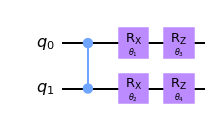

In [3]:
# collapse
qc = QuantumCircuit(2)
qc.cz(0,1)
qc.rx(Parameter('$ \\theta_1 $'), 0)
qc.rx(Parameter('$ \\theta_2 $'), 1)
qc.rz(Parameter('$ \\theta_3 $'), 0)
qc.rz(Parameter('$ \\theta_4 $'), 1)
qc.draw(output='mpl')

Here the entangling gate is the [Controlled-Z](https://qiskit.org/documentation/stubs/qiskit.circuit.library.CZGate.html). This circuit has four parameters and $2^4=16$ associated matrix coefficients $U_I$. What are they, exactly? It is in fact rather simple to understand. If the binary index is $0$ the rotation gate is replaced by the identity, if it is $1$ we insert the generator instead. For example $U_{1110}$ is 

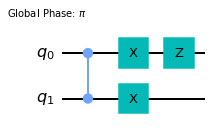

In [4]:
# collapse
qc = QuantumCircuit(2)
qc.cz(0,1)
qc.x(0)
qc.x(1)
qc.z(0)
qc.global_phase=pi
qc.draw(output='mpl')

The global phase arises because $U(\theta=\pi)=-i \Sigma$ for $U(\theta)=e^{-i\theta\Sigma/2}$. Next, consider a more realistic circuit like the one below

<img src="myimages/analytic_vqe/pqc_cz.png" alt="Drawing" style="width: 1000px;"/>

All coefficients $U_I$ arise as $2^p$ different versions of this circuit where each rotation gate is replaced either by an identity or by a generator, just as at the figure above. Although these circuits might all look different, in fact there is just a handful of independent ones. This is due to the following commutation rules, which are easy to check:

<img src="myimages/analytic_vqe/commutation.png" alt="Drawing" style="width: 500px;"/>

These commutation rules allow to move _all the pauli matrices_ past CZ gates and to the beginning of the circuit. For example, the circuit $U_{1101}$ from above can be alternatively be rewritten as

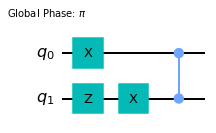

In [5]:
# collapse
qc = QuantumCircuit(2)
qc.x(0)
qc.z(1)
qc.x(1)
qc.cz(0,1)
qc.global_phase=pi
qc.draw(output='mpl')

Then, any string of Pauli matrices is equal to $I, X, Z$ or $Y\simeq XZ$ up to a global phase. So in the end, up to phase factors there are only $4^n$ linearly independent matrices $U_I$ where $n$ is the number of qubits. The counting $4^n$ follows because after all the generators have been placed at the beginning of the circuit there can be only 4 different operators at each qubit thread. Note also that $4^n$ is precisely the dimension of the unitary group on $n$ qubits. We thus see that all of $2^p$ matrix coefficients can be divided into $4^n$ distinct classes and within each class $U_I=e^{i\phi}U_{I'}$. This global phase makes no difference for the averages in \eqref{L average} which can therefore be rewritten as

\begin{align*}
\overline{L}=\frac{1}{4^n}\sum_{c} \langle 0|U_c^\dagger H U_c|0\rangle \ ,
\end{align*}
where now the sum is over representatives of distinct classes. So the sum is reduced from $2^p$ to $4^n$ terms. OK, so how does the number of parameters and the number of qubits compare? Is this really a reduction?

Yes it is! First, if you want your parametrized quantum circuit to cover any unitary transformation on $n$ qubits you need at least $p=4^n$ parameters, because this is the dimension of the unitary group. So in this case we have and exponential reduction from $2^{4^n}$ to $4^n$. But even if you only put two rotation gates on each qubit you already got yourself $4^n$ parameters. Adding anything beyond that, as you definitely wish to do, makes the reduction from $2^p$ to $4^n$ essential. Note though that it is still exponential in the number of qubits and would be unfeasible to compute exactly for a large system. 

## Loss landscape as charge density

OK, here is a brief justification for why I was interested in the average loss in the first place. Generic hamiltonian-agnostic VQE algorithms have in fact lots of trainability issues. One is the presence of the [barren plateaus](https://arxiv.org/abs/1803.11173) in certain regimes, which means that large portions of the parameter space have vanishing gradients and are bad places for optimizer to be in. Another issue is the presence of local minimums which [can be just as bad](https://arxiv.org/abs/2205.05786). So I was wondering if it is possible to somehow use the analytic properties of the VQE loss functions to help mitigate these problems. Here is an idea that probably does not work, but I think still is sort of fun.

Here is an example of a bad loss landscape, sketched in black:
<img src="myimages/analytic_vqe/loss.png" alt="Drawing" style="width: 300px;"/>

It has many local minimums and flat parts, and only a single narrow global minimum. If we are only allowed to probe this loss landscape one value at a time we will have really hard time reaching the global minimum. However, if we have additional information we might be able to do better. 

Let's assume that we know $\Delta^{-1} L(\theta)$ where $\Delta$ is the Laplace operator. [Physics interpretation](https://en.wikipedia.org/wiki/Poisson%27s_equation) is the following. If we view the loss landscape as the charge density $\Delta^{-1}L(\theta)$ is the corresponding electric potential, sketched in red. Minimizing the electric potential instead of the charge density might be a much nicer problem because the electric field (the gradient of the potential field) typically stretches far away from localized charges and can attract the probe. Extreme example is the charge density of the point particle, which is impossible to find unless you trip over it. However, if you can probe the electric field of this charge you have an easy way discovering where it comes from. Sounds good, right? Well, not so fast. First, we do not know $\Delta^{-1}L(\theta)$ for a typical VQE loss. Second, my examples were specifically crafted to sell the idea. It is easy to imagine a loss landscape where this does not help.

But we are not boring nitpickers, are we? Of course not, we are imaginative and brave, so we are going to assume even more. Let's pretend that each successive application of $\Delta^{-1}$ makes our loss landscape better, so we are really interested in 
\begin{align*}
\mathcal{L}(\theta)=\Delta^{-\infty} L(\theta) \ .
\end{align*}
Turns out this limiting landscape is very simple and can be found in a similar way to the average considered in the previous section. Indeed, the loss function \eqref{loss exp} can be represented in the following form 
\begin{align*}
L(\theta)=const+A_1\cos(\theta_1)+B_1\sin(\theta_1)+A_2\cos(\theta_2)+B_2\sin(\theta_2)+A_{12}\cos(\theta_1)\cos(\theta_2)+B_{12}\cos(\theta_1)\sin(\theta_2)+\dots
\end{align*}
This is an example with two parameters and several cross-terms are omitted. Here is the key point -- each cross-term gets smaller under application of $\Delta^{-1}$, e.g. $\Delta^{-1} \cos\theta_1=\cos\theta_1$, $\Delta^{-1} \cos\theta_1\cos\theta_2=\frac12 \cos\theta_1\cos\theta_2$ etc. This means, that under the application of $\Delta^{-\infty}$ only the single-variable terms will survive (we ignore the constant term)
\begin{align*}
\mathcal{L}(\theta)=\Delta^{-\infty}L(\theta)=\sum_{i=1}^{p}\left(A_i\cos\theta_i+B_i\sin\theta_i\right)\,\,\substack{p=2\\=}\,\,A_1\cos(\theta_1)+B_1\sin(\theta_1)+A_2\cos(\theta_2)+B_2\sin(\theta_2)
\end{align*}

These terms are easy to compute if we can compute averages. For example, averaging over all $\theta_i$ except theta $\theta_1$ will only leave the monomials with $\theta_1$
\begin{align*}
A_1\cos{\theta_1}+B_1\sin{\theta_1}=\frac{1}{(2\pi)^{p-1}}\int_0^{2\pi} \prod_{i=2}^pd\theta_i\,\, L(\theta) \ .
\end{align*}
How to perform the average on the rhs was shown in the previous section. Since the limiting loss function $\mathcal{L}(\theta)$ is a sum of single-variable terms it is extremely simple to optimize, and the minumimum is unique

\begin{align*}
\theta^* = (\theta_1^*, \theta_2^*,\dots) = \operatorname{argmin}_\theta \mathcal{L}(\theta) \ .
\end{align*}
The derivation above also gives a different, less exotic, interpretation of $\theta^*$. Each angle $\theta_i^*$ is the angle that minimizes the average loss function, where average is taken with respect to all other angles. Knowing how to find parameter value that optimizes an average performance does not seem like a completely useless information, does it? Could it help to alleviate the problems with barren plateaus or local minimums? I do not know, but I'm planning on making some numerical experiments along these lines.

# Beyond simple trigonometry

I was really impressed with a recent paper [Beyond Barren Plateaus: Quantum Variational Algorithms Are Swamped With Traps](http://arxiv.org/abs/2205.05786c/). Adopting some techniques from the study of neural networks the authors provide a random matrix theory description of a generic loss landscape for Hamiltonian-agnostic VQE. They show that for underparametrized circuits (when the number of parameters $p$ is smaller than the dimension of the unitary group $4^n$, which is basically the only reasonable setup) the loss landscape is really bad, with exponentially many local minimums being located far away (energy-wise) from the global minimum. They even provide an analytic distribution for the expected number of local minimums, which seems to match my numerical experiments rather well:
<img src="myimages/analytic_vqe/theorypractice.png" alt="Drawing" style="width: 800px;"/>
This is yet another piece of evidence showing that complexity of the classical optimization loop in variational algorithms can not be ignored, as if the problems posed by getting a real quantum device to work were not enough. One possible way to alleviate the issues is to use specifically designed parametrized circuits, which are aware of the symmetries or additional properties of the Hamiltonian. I have a feeling though, that even performance of a generic Hamiltonian-agnostic VQE could be improved by exploiting some structural properties of the loss landscapes. In this blog post to speculated about what could such an approach look like.